In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
base = '/Users/maxv/Dropbox (MIT)/inferring_expectations/'

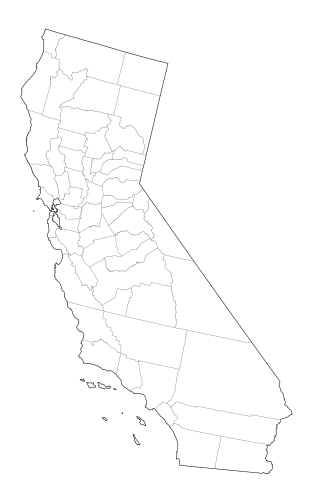

In [3]:
county_fp = base + 'data/shapes/cb_2016_us_county_500k/cb_2016_us_county_500k.shp'
county_df = gpd.read_file(county_fp)
county_df['GEOID'] = county_df['GEOID'].astype('int64')
county_df = county_df[county_df.STATEFP.isin(['06'])]
county_df = county_df.to_crs(epsg=2163) #Sets it to the nice shape
state_fp = base + 'data/shapes/cb_2016_us_state_500k/cb_2016_us_state_500k.shp'
state_df = gpd.read_file(state_fp)
state_df = state_df[state_df.STUSPS.isin(['CA'])]
state_df = state_df.to_crs(epsg=2163)
fig, ax = plt.subplots(1, figsize=(15, 9))
state_df.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
county_df.plot(ax=ax, color='none',edgecolor='grey',linewidth=0.2)
ax.axis('off');

32.534155999999996

In [3]:
"""
Merge county-level SCE maps if needed
"""
# import os
# root = base + 'data/SCE_raw/'
# directories = [os.path.join(root, f) for f in os.listdir(root) if os.path.isdir(os.path.join(root, f))]
# out_df = None
# for path in directories:
#     print(path)
#     gdb = gpd.read_file(path)
#     if out_df is None:
#         out_df = gdb
#     else:
#         out_df = out_df.append(gdb)
#     print(out_df.shape)
# out_df.to_file(base + 'data/SCE/')

sce_gdb = gpd.read_file(base + 'data/ica_maps/SCE')
sce_gdb = sce_gdb[['CIRCUIT_NA','OBJECTID','geometry']].dissolve(by='CIRCUIT_NA').reset_index()
sce_gdb = sce_gdb.to_crs(epsg=2163)
print(sce_gdb.shape)
pge_gdb = gpd.read_file(base + 'data/ica_maps/ICADisplay.gdb')
def name_stub(name):
    """
    Removes number at end of a PGE circuit name string 
    """
    return ''.join(re.split(r'[0-9,.*]*$', name)[:-1])
pge_geo = pge_gdb[['FeederId','FeederName','geometry']].dissolve(by='FeederName').reset_index()
pge_no_num = pge_geo.copy()
pge_no_num['FeederName'] = pge_no_num['FeederName'].apply(name_stub)
pge_no_num = pge_no_num.dissolve(by='FeederName').reset_index()
pge_geo = pge_geo.append(pge_no_num)
pge_geo = pge_geo.to_crs(epsg=2163)
print(pge_geo.shape)
sdge_gdb = gpd.read_file(base + 'data/ica_maps/p20/qa_vaq_elec_portal@viewer.gdb')
sdge_gdb = sdge_gdb.to_crs(epsg=2163)
sdge_circuit_frame = sdge_gdb[['CIRCUIT_NAME','SUBID','geometry']].dissolve(by='CIRCUIT_NAME').reset_index()
print(sdge_circuit_frame.shape)

(1082, 3)
(3690, 3)
(637, 3)


In [7]:
pge_geo.tail()

,FeederName,geometry,FeederId
720,WRIGHT,"MULTILINESTRING ((-1836260.876 -647236.687, -1...",254641110
721,WYANDOTTE,"MULTILINESTRING ((-1825049.812 -369286.790, -1...",102911102
722,YOSEMITE,"MULTILINESTRING ((-1944466.779 -543164.815, -1...",022490401
723,ZACA,"MULTILINESTRING ((-1830169.183 -922745.919, -1...",182681101
724,ZAMORA,"MULTILINESTRING ((-1864783.028 -447889.231, -1...",063191105


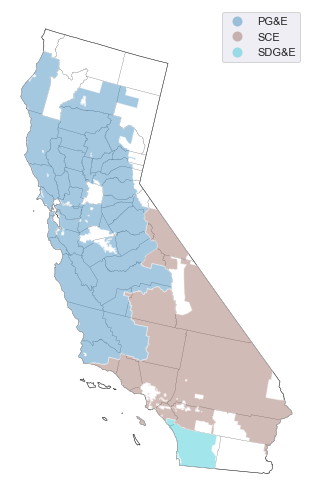

In [11]:
service_area_db = gpd.read_file(base + 'data/Utility_Service_Areas.shp').to_crs(epsg=2163)
service_area_db = service_area_db[service_area_db['Acronym'].isin(['SCE','PG&E','SDG&E'])]
fig, ax = plt.subplots(1, figsize=(15, 9))
state_df.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
county_df.plot(ax=ax, color='none',edgecolor='grey',linewidth=0.2)
ax.axis('off');
service_area_db.plot(ax=ax,column='Acronym',alpha=0.4, legend=True);
plt.show();

In [7]:
overall_df = service_area_db[['Acronym','geometry']]
state_df['Acronym'] = 'ALL_CA'
overall_df = overall_df.append(state_df[['Acronym','geometry']])
overall_df.head()

,Acronym,geometry
55,SCE,MULTIPOLYGON Z (((-1513166.358 -1113763.454 0....
56,PG&E,MULTIPOLYGON Z (((-1990127.784 -138078.023 0.0...
57,SDG&E,MULTIPOLYGON Z (((-1612195.966 -1100481.552 0....
4,ALL_CA,"MULTIPOLYGON (((-1717362.709 -1090134.236, -17..."


In [ ]:
sce_gdb.head()

In [ ]:
pge_geo.head()

In [20]:
psps = pd.read_csv(base + 'data/PSPS_event_data.csv',header=1)
psps=psps.dropna(axis=1,how='all')
initial_length = len(psps)
def convert_to_float(x):
    x = str(x)
    x = x.replace(',','')
    if 'nan' in x.lower(): return np.nan
    if '#value' in x.lower(): return np.nan
    return float(x)
psps['Outage Hours'] = psps['Outage Hours'].apply(convert_to_float)
psps = psps[psps['Outage Hours'] >= 0]
print("Dropped {} entries with negative outage hours".format(initial_length - len(psps)))
psps.head()

Dropped 40 entries with negative outage hours


,Utility,Outage Start,Full Restoration,Outage Duration,Outage Days,Outage Hours,Circuit Name,HFTD,TOTAL CUSTOMERS IMPACTED,RESIDENTIAL CUSTOMERS,COMMERCIAL/INDUSTRIAL CUSTOMERS,MEDICAL BASELINE CUSTOMERS,OTHER CUSTOMERS,Notes
0,SDG&E,10/5/13 6:02,10/5/13 14:55,"0 days,8 hrs,53 min",0.370,8.88,79,NaN,85,NaN,NaN,NaN,NaN,NaN
1,SDG&E,10/5/13 6:05,10/5/13 14:41,"0 days,8 hrs,36 min",0.358,8.60,TL 626 - CIRCUIT 238,NaN,2,NaN,NaN,NaN,NaN,NaN
2,SDG&E,10/6/13 2:03,10/6/13 8:10,"0 days,6 hrs,7 min",0.255,6.12,79,NaN,83,NaN,NaN,NaN,NaN,NaN
3,SDG&E,10/6/13 2:10,10/6/13 8:10,"0 days,6 hrs,0 min",0.250,6.00,79,NaN,11,NaN,NaN,NaN,NaN,NaN
4,SDG&E,10/6/13 2:13,10/6/13 7:44,"0 days,5 hrs,31 min",0.230,5.52,TL 626 - CIRCUIT 238,NaN,2,NaN,NaN,NaN,NaN,NaN


In [21]:
def clean_name(name):
    if str(name)[-2:] == '*3': name = name.split('*3')[0]
    name = str(name).lower().strip()
    name = name.replace('-',' ')
    name = name.replace('–',' ')
    name = name.replace('*',' ')
    name = name.replace('  ',' ')
    name = name.replace('  ',' ')
    name = re.split(r'\[[0-9,.]\]',name)[0].strip()
    name = name.strip()
    return name
psps['clean_name'] = psps['Circuit Name'].apply(clean_name)
sce_gdb['clean_name'] = sce_gdb['CIRCUIT_NA'].apply(clean_name)
pge_geo['clean_name'] = pge_geo['FeederName'].apply(clean_name)
sdge_circuit_frame['clean_name'] = sdge_circuit_frame['CIRCUIT_NAME'].apply(clean_name)


In [22]:
sce_circuit_names = pd.unique(sce_gdb.clean_name)
def sce_translate_name(name, circuit_names):
    """
    Looks for a match to a name from PSPS circuit names
    to the SCE circuit map names
    Returns the match name, if found, or None if not 
    """
    name = str(name).lower().strip()
#     name = name.replace('\xa0',' ')
    if name in circuit_names: return name
    if ' (fed by' in name:
        name = name.split(' (fed by')[0].strip()
        if name in circuit_names: return name 
    if name[-2:] == 'kv':
        name = re.split(r'[0-9,.]+kv',name)[0].strip()
        if name in circuit_names: return name
    if name == 'mora': return 'casmalia'
    if name == 'taiwain': return 'taiwan'
    if name == 'horse mountain 2.4': return 'horse mountain'
    if name == 'loucks pt': return 'loucks'
    return None
psps['clean_name'] = np.where(psps['Utility'].isin(['SCE']), 
                              [sce_translate_name(name, sce_circuit_names) for name in psps.clean_name],
                             psps.clean_name)

In [23]:
pge_circuit_names = pd.unique(pge_geo.clean_name)
def pge_translate_name(name, circuit_names):
    """
    Looks for a match to a name from PSPS circuit names
    to the PGE circuit map names
    Returns the match name, if found, or None if not 
    """
    name = clean_name(name)
#     name = name.replace('\xa0',' ')
    if name in circuit_names: return name
    if 'big bend1102' == name: 
        new_name = 'big bend 1102'
        if new_name in circuit_names: return new_name
    if 'wyandotte1110' == name:
        new_name = 'wyandotte 1110'
        if new_name in circuit_names: return new_name
    if 'san joaquin power house no 2' in name:
        new_name = name.replace('san joaquin power house no 2','san joaquin #2')
        if new_name in circuit_names: return new_name
    if ('san joaquin' in name) and ('ph 11' in name):
        new_name = name.replace('ph 11','11')
        if new_name in circuit_names: return new_name
    if name [-4:] == 'line':
        new_name = name.split('line')[0].strip()
        if new_name in circuit_names: return new_name
    if name[-2:] == 'kv':
        new_name = re.split(r'[0-9,.]+kv',name)[0].strip()
        if new_name in circuit_names: return new_name
    if 'peoria flat' in name:
        new_name = name.replace('peoria flat', 'peoria')
        if new_name in circuit_names: return new_name
    if 'sycamore reek' in name:
        new_name = name.replace('reek', 'creek')
        if new_name in circuit_names: return new_name
    if 'san leandro' in name:
        new_name = name.replace('san leandro', 'san leandro u')
        if new_name in circuit_names: return new_name
    if 'vallejo sta c' in name:
        new_name = name.replace('vallejo sta c', 'vallejo c')
        if new_name in circuit_names: return new_name
    return None
psps['clean_name'] = np.where(psps['Utility'].isin(['PGE','PG&E']), 
                              [pge_translate_name(name, pge_circuit_names) for name in psps.clean_name],
                             psps.clean_name)

In [24]:
sdge_circuit_names = pd.unique(sdge_circuit_frame.clean_name)
def sdge_translate_name(name, circuit_names):
    """
    Looks for a match to a name from PSPS circuit names
    to the SDGE circuit map names
    Returns the match name, if found, or None if not 
    """
    name = clean_name(name)
#     name = name.replace('\xa0',' ')
    if name in circuit_names: return name
    if ' ' in name: 
        new_name = name.split(' ')[0]
        if new_name in circuit_names: 
            return new_name
    if 'cb' in name:
        new_name = clean_name(name.split('cb')[1])
        if new_name in circuit_names:
            return new_name
    if ', ' in name:
        new_name = name.split('gc sub')[1].strip() if 'gc sub' in name else name
        new_name = new_name.split(', ')
        if all([_name in circuit_names for _name in new_name]): 
            print(new_name)
            return ', '.join(new_name)
    return None
psps['clean_name'] = np.where(psps['Utility'].isin(['SDGE','SDG&E']), 
                              [sdge_translate_name(name, sdge_circuit_names) for name in psps.clean_name],
                             psps.clean_name)
for name in psps[psps['Utility'].isin(['SDGE','SDG&E'])].clean_name:
    if name in sdge_circuit_frame.clean_name: continue
    if name is None: continue
    if ', ' in name:
        name_1 = name.split(', ')[0]        
        name_2 = name.split(', ')[1]
        geo_subset = sdge_circuit_frame[sdge_circuit_frame.clean_name.isin([name_1, name_2])].copy()
        geo_subset['clean_name'] = name
        geo_subset = geo_subset.dissolve(by='clean_name').reset_index()
        sdge_circuit_frame = sdge_circuit_frame.append(geo_subset)

['448', '449']
['441', '442']


In [25]:
overall_geo = sce_gdb[['clean_name', 'geometry']].append(pge_geo[['clean_name', 'geometry']]).append(sdge_circuit_frame[['clean_name', 'geometry']])
psps_geo = overall_geo.merge(psps, on='clean_name')
psps_geo['Utility'] = psps_geo['Utility'].apply(lambda x: x.replace('&',''))
psps_geo.head()

,clean_name,geometry,Utility,Outage Start,Full Restoration,Outage Duration,Outage Days,Outage Hours,Circuit Name,HFTD,TOTAL CUSTOMERS IMPACTED,RESIDENTIAL CUSTOMERS,COMMERCIAL/INDUSTRIAL CUSTOMERS,MEDICAL BASELINE CUSTOMERS,OTHER CUSTOMERS,Notes
0,accent,"MULTILINESTRING ((-1579980.231 -1073143.190, -...",SCE,1/19/21 12:40,1/19/21 21:54,"0 days,9 hrs,13 min",0.385,9.23,ACCENT,T2,1584,1477,26,81,0,NaN
1,acosta,"MULTILINESTRING ((-1601640.205 -1036273.404, -...",SCE,10/10/19 8:14,10/12/19 10:05,"2 days,1 hrs,51 min",2.077,49.85,ACOSTA,Tier 2/Tier 3,5,0,0,0,0,NaN
2,acosta,"MULTILINESTRING ((-1601640.205 -1036273.404, -...",SCE,10/24/19 4:48,10/25/19 14:28,"1 days,9 hrs,40 min",1.403,33.67,Acosta 12kV,Tier 2/Tier 3,1243,1139,63,36,99,NaN
3,acosta,"MULTILINESTRING ((-1601640.205 -1036273.404, -...",SCE,10/28/19 6:49,10/29/19 9:55,"1 days,3 hrs,6 min",1.129,27.10,ACOSTA,NaN,1243,1139,63,36,NaN,NaN
4,acosta,"MULTILINESTRING ((-1601640.205 -1036273.404, -...",SCE,10/30/19 1:30,11/1/19 11:53,"2 days,10 hrs,23 min",2.433,58.38,ACOSTA,NaN,1243,1139,63,36,NaN,NaN


In [26]:
psps_geo.to_file(base + 'data/psps_events/psps_events.shp')

/var/folders/10/m_drqhg91g179r68n5cmd1zw0000gn/T/ipykernel_424/3678866040.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  psps_geo.to_file(base + 'data/psps_events/psps_events.shp')


<AxesSubplot:>

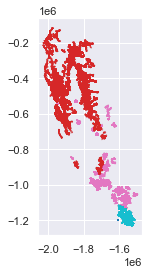

In [15]:
psps_geo.plot(column='Utility')

In [ ]:
psps_geo['start_date'] = pd.to_datetime(psps_geo['Outage Start']).dt.date
psps_geo['year'] = pd.to_datetime(psps_geo['Outage Start']).dt.year
def convert_to_int(x):
    x = str(x)
    x = x.replace(',','')
    if 'nan' in x.lower(): return np.nan
    return int(x)
total_customer_hours = psps_geo.copy()
total_customer_hours['total_customer_hours'] = total_customer_hours['TOTAL CUSTOMERS IMPACTED'].apply(convert_to_int) \
            * total_customer_hours['Outage Hours'].astype(float)
total_customer_hours = total_customer_hours.groupby(['clean_name','start_date'])['total_customer_hours'].sum()
merged_geo = psps_geo.dissolve(by = ['clean_name','start_date'])
merged_geo = merged_geo.merge(total_customer_hours, left_index=True, right_index=True)
merged_geo.head()

In [ ]:
counts_by_name= psps_geo.groupby(['clean_name','start_date']).mean().reset_index().groupby(['clean_name']).count().reset_index()
counts_by_name['count'] = counts_by_name['start_date']
counts_geo = psps_geo.dissolve(by=['clean_name']).reset_index()
counts_geo = counts_geo.merge(counts_by_name[['clean_name', 'count']], on='clean_name')
fig, ax = plt.subplots(1, figsize=(15, 9))
state_df.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
county_df.plot(ax=ax, color='none',edgecolor='grey',linewidth=0.2)
ax.axis('off');
service_area_db.plot(ax=ax,column='Acronym',alpha=0.4,legend=True);
overall_geo.plot(ax=ax, alpha=0.2, linewidth=0.2, edgecolor='blue')
counts_geo.plot(ax=ax, column='count',legend=True)
plt.show();

In [ ]:
counts_geo.head()

In [ ]:
import folium
m = folium.Map([33, -117], zoom_start=7, tiles='cartodbpositron')
folium.GeoJson(counts_geo[['count','geometry']]).add_to(m)
# folium.GeoJson(polygon_geom2).add_to(m)
# folium.LatLngPopup().add_to(m)
m

In [ ]:
for year in range(2018,2022):
    counts_by_name= psps_geo[psps_geo.year == year].groupby(['clean_name','start_date']).mean().reset_index().groupby(['clean_name']).count().reset_index()
    counts_by_name['count'] = counts_by_name['start_date']
    counts_geo = psps_geo[psps_geo.year == year].dissolve(by=['clean_name']).reset_index()
    counts_geo = counts_geo.merge(counts_by_name[['clean_name', 'count']], on='clean_name')
    fig, ax = plt.subplots(1, figsize=(15, 9))
    state_df.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
    county_df.plot(ax=ax, color='none',edgecolor='grey',linewidth=0.2)
    ax.axis('off');
    service_area_db.plot(ax=ax,column='Acronym',alpha=0.4,legend=True);
    counts_geo.plot(ax=ax, column='count',legend=True)
    plt.show();

In [ ]:
counts_by_name.head()

In [ ]:
fig, ax = plt.subplots(1, figsize=(15, 9))
state_df.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
county_df.plot(ax=ax, color='none',edgecolor='grey',linewidth=0.2)
ax.axis('off');
service_area_db.plot(ax=ax,column='Acronym',alpha=0.4);
merged_geo.plot(ax=ax, column='total_customer_hours',legend=True)
plt.show();

In [ ]:
min(merged_geo['Outage Hours'].astype(float))

In [ ]:
psps[psps['Utility'].isin(['SDGE', 'SDG&E'])][['Circuit Name','clean_name']]